In [1]:
# SETUP pyDR
import os
os.chdir('..')
import sys
sys.path.append('../') # Path to pyDR location

In [2]:
# Import various modules, including the pyDR module
import pyDR   #Import the pyDR software, which includes functions for calculating NMR relaxation rate constants
from pyDR.misc.tools import linear_ex #Convenient tool for interpolating between data points
import numpy as np #Lots of nice linear algebra tools
from scipy.optimize import minimize
import matplotlib.pyplot as plt #Plotting tools

#Zoomable plots with matplotlib notebook
# %matplotlib notebook

z=[-11,-9.5,-7.5]  #These are log-correlation times, corresponding to 10 ps, 1 ns, and 1 μs, respectively
A=[.2,.05,.01]  #These are the corresponding amplitudes. The total amplitude of motion is 0.38 (S^2=0.62)

nmr=pyDR.Sens.NMR()  #This is a container for NMR experiments, which give the relaxation rates as a function of z
nmr.new_exper(Type='R1',v0=[400,600,800],Nuc='15N') #Add 3 experiments: 15N T1 at 400, 600, and 800
#We assume by default N15 coupled to a single proton (22.954 kHz = 2*11.477) and CSA of 113 ppm (z-component)
nmr.new_exper(Type='R1p',v0=800,vr=60,v1=10,Nuc='15N') #Add an R1p (MAS=60 kHz, spin-lock at 10 kHz)
nmr.new_exper(Type='S2')
labels=[r'$R_1$(400 MHz)',r'$R_1$(600 MHz)',r'$R_1$(800 MHz)',
        r'$R_{1\rho}$',r'$1-S^2$']
ax=plt.subplots()[1]
nmr.plot_Rz(norm=True,ax=ax) #Plot the 9 relaxation rate constants (normalized to max of 1) vs tc
_=ax.legend(labels)

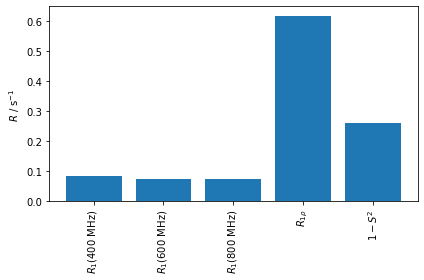

In [3]:
R=np.zeros(nmr.rhoz.shape[0])  #Pre-allocate an array with 7 relaxation rates
for z0,A0 in zip(z,A):    #Iterate over all correlation times, amplitudes
    R+=A0*linear_ex(nmr.z,nmr.rhoz,z0)

ax=plt.subplots()[1]
ax.bar(range(len(R)),R)
#Some figure cleanup/labeling
ax.set_xticks(range(len(R)))
ax.set_xticklabels(labels,rotation=90)
ax.set_ylabel(r'$R$ / s$^{-1}$')
ax.figure.tight_layout()

In [4]:
#Function to calculate relaxation rate constants
def calcR(z,A,nmr):
    R=np.zeros(nmr.rhoz.shape[0])
    for z0,A0 in zip(z,A):    #Iterate over all correlation times, amplitudes
        R+=A0*linear_ex(nmr.z,nmr.rhoz,z0)
    return R

#Function to calculate error of fit
def error(zf,Af):
    Ri=calcR(z,A,nmr)
    Rc=calcR(zf,Af,nmr)
    return np.sum((Ri-Rc)**2)

# Function to use with nonlinear minimization algorithm (needs to have just one argument)
def fun(x):
    zf=x[:len(x)//2]
    Af=x[len(x)//2:]
    return error(zf,Af)

In [5]:
fit=minimize(fun,[-10,-9,-7,.2,.1,.05],bounds=([-14,-6],[-14,-6],[-14,-6],[0,1],[0,1],[0,1]))   
zf,Af=fit['x'][:3],fit['x'][3:]
Rc=calcR(zf,Af,nmr)

print(f'Error is {fit["fun"]} (should be small– otherwise adjust initial guess)')

Error is 6.5735314936268175e-06 (should be small– otherwise adjust initial guess)


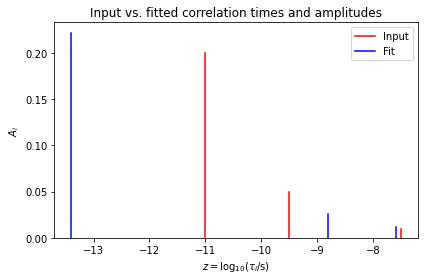

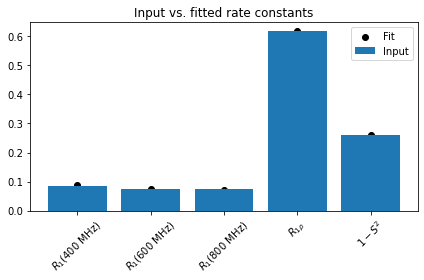

In [6]:
#Plot the results
ax=plt.subplots()[1]
for z0,A0 in zip(z,A):
    hdl0=ax.plot([z0,z0],[0,A0],color='red',label='Input' if z0==z[-1] else None)
for z0,A0 in zip(zf,Af):
    hdl1=ax.plot([z0,z0],[0,A0],color='blue',label='Fit' if z0==zf[-1] else None)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'$z=\log_{10}(\tau_i/\mathrm{s})$')
ax.set_ylabel(r'$A_i$')
ax.legend()
ax.set_title('Input vs. fitted correlation times and amplitudes')
ax.figure.tight_layout()

ax=plt.subplots()[1]
ax.bar(range(len(R)),R,label='Input')
ax.scatter(range(len(Rc)),Rc,color='black',marker='o',label='Fit')
ax.legend()
ax.set_xticks(range(len(Rc)))
ax.set_xticklabels(labels,rotation=45)
ax.set_title('Input vs. fitted rate constants')
ax.figure.tight_layout()

In [7]:
fit=minimize(fun,[-10,-8.5,.2,.01],bounds=([-14,-6],[-14,-6],[0,1],[0,1]))   
zf,Af=fit['x'][:2],fit['x'][2:]
Rc=calcR(zf,Af,nmr)

print(f'Error is {fit["fun"]} (should be small– otherwise adjust initial guess)')

Error is 4.299449423051208e-07 (should be small– otherwise adjust initial guess)


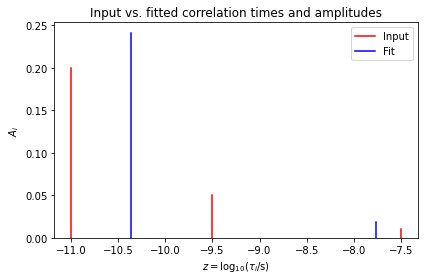

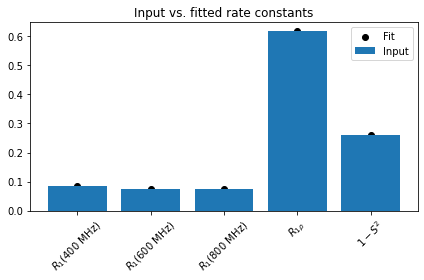

In [8]:
#Plot the results
ax=plt.subplots()[1]
for z0,A0 in zip(z,A):
    hdl0=ax.plot([z0,z0],[0,A0],color='red',label='Input' if z0==z[-1] else None)
for z0,A0 in zip(zf,Af):
    hdl1=ax.plot([z0,z0],[0,A0],color='blue',label='Fit' if z0==zf[-1] else None)
ax.set_ylim([0,ax.get_ylim()[1]])
ax.set_xlabel(r'$z=\log_{10}(\tau_i/\mathrm{s})$')
ax.set_ylabel(r'$A_i$')
ax.legend()
ax.set_title('Input vs. fitted correlation times and amplitudes')
ax.figure.tight_layout()

ax=plt.subplots()[1]
ax.bar(range(len(R)),R,label='Input')
ax.scatter(range(len(Rc)),Rc,color='black',marker='o',label='Fit')
ax.legend()
ax.set_xticks(range(len(Rc)))
ax.set_xticklabels(labels,rotation=45)
ax.set_title('Input vs. fitted rate constants')
ax.figure.tight_layout()

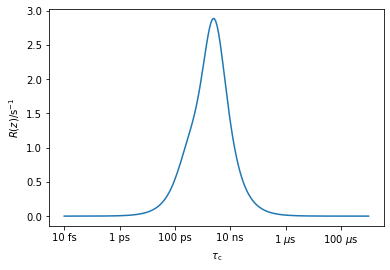

In [9]:
_=pyDR.Sens.NMR(Type='R1',Nuc='15N',v0=600).plot_Rz()

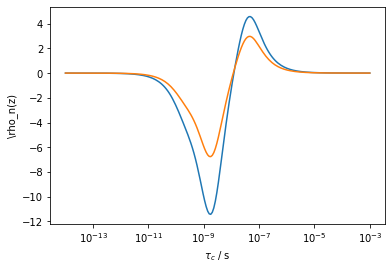

In [10]:
nmr=pyDR.Sens.NMR(Type='R1',v0=[40,800],Nuc='15N')
rho_0=nmr.rhoz[0]*10*(np.random.rand()-.5)+nmr.rhoz[1]*10*(np.random.rand()-.5)
rho_1=nmr.rhoz[0]*10*(np.random.rand()-.5)+nmr.rhoz[1]*10*(np.random.rand()-.5)
ax=plt.subplots()[1]
ax.semilogx(nmr.tc,rho_0)
ax.semilogx(nmr.tc,rho_1)
ax.set_xlabel(r'$\tau_c$ / s')
_=ax.set_ylabel(r'\rho_n(z)')

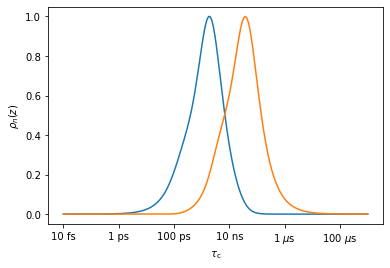

In [11]:
_=nmr.Detector().r_auto(2).plot_rhoz()